# Codon Frequencies
This notebook parses FASTQ files and calculates the frequency of codons at site 734 in Zika Virus NS5 protein.

FASTQ files for each cell population are specified in `samplesheet.csv`

### Notebook setup
Imports

In [1]:
import gzip
import os.path
import numpy as np
import pandas as pd
import plotnine as p9
import regex
from Bio import SeqIO

# print imports and versions
# copied from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' \
                for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.19.1
pandas==1.3.2
plotnine==0.8.0
regex==2.5.83


Input data

In [2]:
samplesheet = 'samplesheet.csv'
reference_file = 'ns5.fasta'
codons_file = 'codon_counts.csv.gz'
codon_lookup_file = 'codon_lookup_table.csv'

Analysis parameters

In [3]:
codon_start = 2203  # nposition in reference for first codon nt
upstream_length = 15  # length of sequence before codon to search for
downstream_length = 15  # length of sequence after codon to search for
mismatches = 1  # number of mismatches allowed (per upstream/downstream sequence)
nucleotides_allowed = 'ACGT'  # bases permitted in parsed codon

Notebook aesthetics

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_RICH = ['#648FFF', '#FFB000', '#DC267F', '#785EF0', '#FE6100']

### Load data
Load samples

In [5]:
samples = pd.read_csv(samplesheet)
display(samples)

,sample_name,infected,IFN,read,fastq_file
0,WT_NS5_Sample,True,None,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
1,Mut_NS5_Sample,True,None,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
2,Mut_Rnd1_mCherry_neg,True,False,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
3,Mut_Rnd1_mCherry_pos,True,True,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
4,Mut_Rnd2_mCherry_neg,True,False,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
5,Mut_Rnd2_mCherry_pos,True,True,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
6,WT_Plasmid,None,None,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
7,Mut_Plasmid,None,None,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
8,WT_NS5_Sample,True,None,R2,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
9,Mut_NS5_Sample,True,None,R2,/shared/ngs/illumina/bloom_lab/210917_M04866_0...


Load reference sequence

In [6]:
reference = SeqIO.read(reference_file, 'fasta')
print(reference.id)
print(reference.seq)

NS5
CGTGGAGGTGGGACGGGAGAGACTCTGGGAGAGAAGTGGAAAGCTCGTCTGAATCAGATGTCGGCCCTGGAGTTCTACTCTTATAAAAAGTCAGGTATCACTGAAGTGTGTAGAGAGGAGGCTCGCCGTGCCCTCAAGGATGGAGTGGCCACAGGAGGACATGCCGTATCCCGGGGAAGTGCAAAGCTCAGATGGTTGGTGGAGAGAGGATATCTGCAGCCCTATGGGAAGGTTGTTGACCTCGGATGTGGCAGAGGGGGCTGGAGCTATTATGCCGCCACCATCCGCAAAGTGCAGGAGGTGAGAGGATACACAAAGGGAGGTCCCGGTCATGAAGAACCCATGCTGGTGCAAAGCTATGGGTGGAACATAGTTCGTCTCAAGAGTGGAGTGGACGTCTTCCACATGGCGGCTGAGCCGTGTGACACTCTGCTGTGTGACATAGGTGAGTCATCATCTAGTCCTGAAGTGGAAGAGACACGAACACTCAGAGTGCTCTCTATGGTGGGGGACTGGCTTGAAAAAAGACCAGGGGCCTTCTGTATAAAGGTGCTGTGCCCATACACCAGCACTATGATGGAAACCATGGAGCGACTGCAACGTAGGCATGGGGGAGGATTAGTCAGAGTGCCATTGTCTCGCAACTCCACACATGAGATGTACTGGGTCTCTGGGGCAAAGAGCAACATCATAAAAAGTGTGTCCACCACAAGTCAGCTCCTCCTGGGACGCATGGATGGCCCCAGGAGGCCAGTGAAATATGAGGAGGATGTGAACCTCGGCTCGGGTACACGAGCTGTGGCAAGCTGTGCTGAGGCTCCTAACATGAAAATCATCGGCAGGCGCATTGAGAGAATCCGCAATGAACATGCAGAAACATGGTTTCTTGATGAAAACCACCCATACAGGACATGGGCCTACCATGGGAGCTACGAAGCCCCCACGCAAGGATCAGCGTCTTCCCTCGTGAACGGGGTTGTTAGACTCCTGTCAAAG

### Parse codon sequence
If codons file is present, open codon counts.

Otherwise, parse codons from FASTQ files listed in samplesheet.

Open codons file if present

In [7]:
if os.path.isfile(codons_file):
    print(f'Loading results from {codons_file}')
    results = pd.read_csv(codons_file)
    print('Done.')
else:
    pass

Loading results from codon_counts.csv.gz
Done.


Extract sequences upstream and downstream of codon

In [8]:
# feature positions in reference sequence
codon_end = codon_start + 2
upstream_start = codon_start - upstream_length
upstream_end = codon_start - 1
downstream_start = codon_end + 1
downstream_end = codon_end + downstream_length

# feature values
# python indexing is not inclusive of first coordinate, so
# all start positions are adjusted by -1
codon_reference = reference.seq[(codon_start-1):codon_end]
upstream = reference.seq[(upstream_start-1):upstream_end]
downstream = reference.seq[(downstream_start-1):downstream_end]

# print
print(f'The codon starts at position {codon_start} and '
      f'ends at position {codon_end} in the reference.')
print(f'The WT codon sequence in the reference is: {codon_reference}\n')
print(f'The upstream search sequence starts at position {upstream_start} '
      f'and ends at position {upstream_end} in the reference.')
print(f'The upstream search sequence is: {upstream}\n')
print(f'The downstream search sequence starts at position {downstream_start} '
      f'and ends at position {downstream_end} in the reference.')
print(f'The downstream search sequence is: {downstream}')

The codon starts at position 2203 and ends at position 2205 in the reference.
The WT codon sequence in the reference is: GAT

The upstream search sequence starts at position 2188 and ends at position 2202 in the reference.
The upstream search sequence is: CCTTGCCGCCACCAA

The downstream search sequence starts at position 2206 and ends at position 2220 in the reference.
The downstream search sequence is: GAACTGATTGGCCGA


Build regex search

In [9]:
pattern = (f'(?:{upstream}){{e<={mismatches}}}' +  # match upstream
              f'([{nucleotides_allowed}]{{3}})' +  # match and capture codon
              f'(?:{downstream}){{e<={mismatches}}}')  # match downstream
print(f'The search pattern for will be:\n{pattern}')

The search pattern for will be:
(?:CCTTGCCGCCACCAA){e<=1}([ACGT]{3})(?:GAACTGATTGGCCGA){e<=1}


Iterate through reads and store codons:

In [10]:
if os.path.isfile(codons_file):
    pass
else:
    results = list()

    for index, sample in samples.iterrows():
        assert sample['read'] in ['R1', 'R2'], "unrecognized read"
        with gzip.open(sample['fastq_file'], mode='rt') as handle:
            print(f'Parsing data for {sample["sample_name"]} {sample["read"]}')
            print(f'File is:  {sample["fastq_file"]}')
            seqs = SeqIO.parse(handle, 'fastq')
            for sequence in seqs:
                if(sample['read'] == 'R1'):
                    search_seq = sequence.seq
                elif(sample['read'] == 'R2'):
                    search_seq = sequence.seq.reverse_complement()
                result = regex.search(pattern, str(search_seq))
                if result == None:
                    match = 'failed_parse'
                    codon = 'failed_parse'
                else:
                    match = result.group(0)
                    codon = result.group(1)
                results.append((sample['sample_name'],
                                sample['read'],
                                sequence.id,
                                match,
                                codon))
            print('\n')

    results = pd.DataFrame(results)
    results.columns = ['sample_name','read','read_id','match_string','codon']
    print(f'Saving results to {codons_file}')
    results.to_csv(codons_file, index=False)

In [11]:
display(results)

,Unnamed: 0,sample_name,read,read_id,match_string,codon
0,0,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17362:1802,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT
1,1,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:18222:1836,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT
2,2,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17286:1855,CCCTTGCCGCCACCAACATGAACTGATTGGCCGA,CAT
3,3,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:16342:1902,CCCTTGCCGCCACCAATATGAACTGATTGGCCGA,TAT
4,4,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:16389:1914,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT
...,...,...,...,...,...,...
24292555,24292555,Mut_Plasmid,R2,M04866:509:000000000-JW58W:1:2114:17153:29217,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT
24292556,24292556,Mut_Plasmid,R2,M04866:509:000000000-JW58W:1:2114:16532:29221,CCCTTGCCGCCACCAACGCGAACTGATTGGCCGA,CGC
24292557,24292557,Mut_Plasmid,R2,M04866:509:000000000-JW58W:1:2114:16271:29222,CCCTTGCCGCCACCAATGTGAACTGATTGGCCGA,TGT
24292558,24292558,Mut_Plasmid,R2,M04866:509:000000000-JW58W:1:2114:17379:29224,CCCTTGCCGCCACCAATGGGAACTGATTGGCCGA,TGG


### Quality control

Plot number of reads with codon successfully parsed per sample

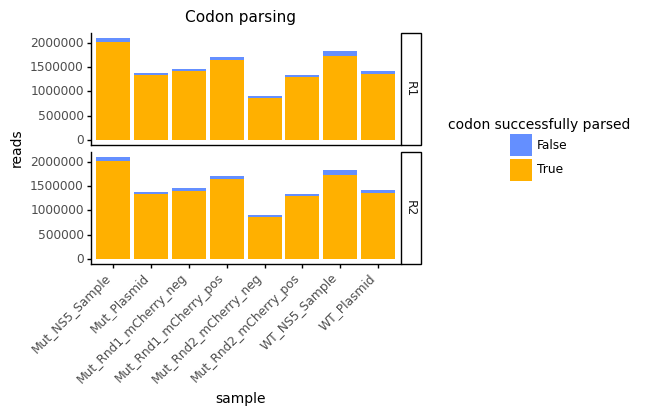

<ggplot: (8760581725672)>

In [12]:
parsing_qc = (p9.ggplot(results) +
              p9.aes(x='sample_name',
                     fill='codon != "failed_parse"') +
              p9.geom_bar(stat='count') +
              p9.facet_grid('read~') +
              p9.ggtitle('Codon parsing') +
              p9.labs(x='sample',
                      y='reads',
                      fill='codon successfully parsed') +
              p9.theme(figure_size=(0.5*samples['sample_name'].nunique(), 
                                    1.5*samples['read'].nunique()),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(parsing_qc)

Pair reads by read_id

In [13]:
results_pairs = (
    results
    .pivot(index=['sample_name','read_id'], columns='read', values='codon')
    .reset_index())

#  Check for missing mate
results_pairs['missing_mate'] = (
    results_pairs['R1'].isnull() | results_pairs['R2'].isnull()
)

#  Check for mismatch
results_pairs['pair_mismatch'] = (
    results_pairs['R1'] != results_pairs['R2']
)

display(results_pairs)

read,sample_name,read_id,R1,R2,missing_mate,pair_mismatch
0,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:22059,CGC,CGC,False,False
1,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:26661,CCT,CCT,False,False
2,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:26942,ATG,ATG,False,False
3,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:4907,CAC,CAC,False,False
4,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:6247,CCT,CCT,False,False
...,...,...,...,...,...,...
12146275,WT_Plasmid,M04866:509:000000000-JW58W:1:2114:9999:11460,GAT,GAT,False,False
12146276,WT_Plasmid,M04866:509:000000000-JW58W:1:2114:9999:21670,GAT,GAT,False,False
12146277,WT_Plasmid,M04866:509:000000000-JW58W:1:2114:9999:23761,GAT,GAT,False,False
12146278,WT_Plasmid,M04866:509:000000000-JW58W:1:2114:9999:5577,GAT,GAT,False,False


Plot missing mates

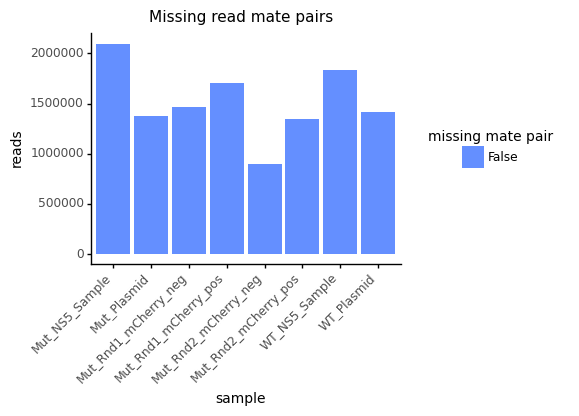

<ggplot: (8760581605069)>

In [14]:
mate_pair_qc = (p9.ggplot(results_pairs) +
              p9.aes(x='sample_name',
                     fill='missing_mate') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('Missing read mate pairs') +
              p9.labs(x='sample',
                      y='reads',
                      fill='missing mate pair') +
              p9.theme(figure_size=(0.5*samples['sample_name'].nunique(), 
                                    1.5*samples['read'].nunique()),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(mate_pair_qc)

Plot mismatched codon values from paired reads

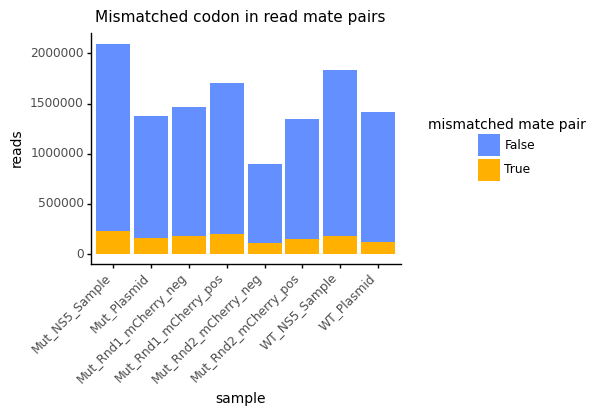

<ggplot: (8760581602964)>

In [15]:
mismatched_pairs_qc = (p9.ggplot(results_pairs) +
              p9.aes(x='sample_name',
                     fill='pair_mismatch') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('Mismatched codon in read mate pairs') +
              p9.labs(x='sample',
                      y='reads',
                      fill='mismatched mate pair') +
              p9.theme(figure_size=(0.5*samples['sample_name'].nunique(), 
                                    1.5*samples['read'].nunique()),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(mismatched_pairs_qc)

### Error rate
Calculate the error rate for this system. Simply calculate the fraction of reads that are *not WT* for sample expected to be 100% WT.


Label WT codons

In [16]:
results['wt'] = (results['codon'] == 'GAT')
display(results)

,Unnamed: 0,sample_name,read,read_id,match_string,codon,wt
0,0,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17362:1802,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT,False
1,1,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:18222:1836,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT,False
2,2,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17286:1855,CCCTTGCCGCCACCAACATGAACTGATTGGCCGA,CAT,False
3,3,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:16342:1902,CCCTTGCCGCCACCAATATGAACTGATTGGCCGA,TAT,False
4,4,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:16389:1914,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT,False
...,...,...,...,...,...,...,...
24292555,24292555,Mut_Plasmid,R2,M04866:509:000000000-JW58W:1:2114:17153:29217,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT,False
24292556,24292556,Mut_Plasmid,R2,M04866:509:000000000-JW58W:1:2114:16532:29221,CCCTTGCCGCCACCAACGCGAACTGATTGGCCGA,CGC,False
24292557,24292557,Mut_Plasmid,R2,M04866:509:000000000-JW58W:1:2114:16271:29222,CCCTTGCCGCCACCAATGTGAACTGATTGGCCGA,TGT,False
24292558,24292558,Mut_Plasmid,R2,M04866:509:000000000-JW58W:1:2114:17379:29224,CCCTTGCCGCCACCAATGGGAACTGATTGGCCGA,TGG,False


WT vs mutant codons

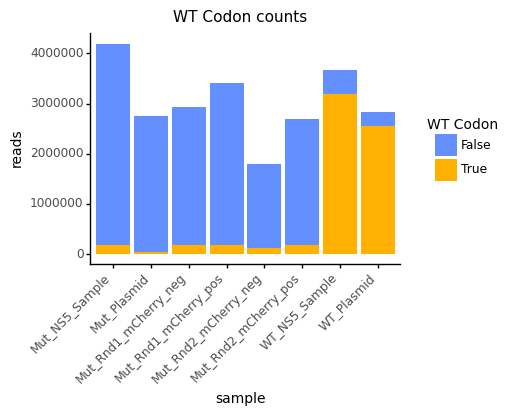

<ggplot: (8760581531781)>

In [17]:
wt_counts = (p9.ggplot(results) +
              p9.aes(x='sample_name',
                     fill='wt') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('WT Codon counts') +
              p9.labs(x='sample',
                      y='reads',
                      fill='WT Codon') +
              p9.theme(figure_size=(0.5*samples['sample_name'].nunique(), 
                                    1.5*samples['read'].nunique()),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(wt_counts)

In [18]:
wt_freq = (
    results
    .query('sample_name.str.contains("WT")', engine='python')
    .groupby('sample_name')
    ['wt']
    .value_counts(normalize=True)
    .reset_index(name='wt_frac')
)

print('The error rate observed in WT samples is:')
display(wt_freq.query('wt == False'))

The error rate observed in WT samples is:


,sample_name,wt,wt_frac
1,WT_NS5_Sample,False,0.134936
3,WT_Plasmid,False,0.095583


### Filter data
Filter the data based on the QC metrics above.

In [19]:
results_filtered = (
    results_pairs
    .query(
        'missing_mate == False & '
        'pair_mismatch == False & '
        'R1 != "failed_parse" & '
        'R2 != "failed_parse"')
    [['sample_name', 'read_id', 'R1']]
    .rename(columns={'R1': 'codon'})
)

display(results_filtered)

read,sample_name,read_id,codon
0,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:22059,CGC
1,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:26661,CCT
2,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:26942,ATG
3,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:4907,CAC
4,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:6247,CCT
...,...,...,...
12146275,WT_Plasmid,M04866:509:000000000-JW58W:1:2114:9999:11460,GAT
12146276,WT_Plasmid,M04866:509:000000000-JW58W:1:2114:9999:21670,GAT
12146277,WT_Plasmid,M04866:509:000000000-JW58W:1:2114:9999:23761,GAT
12146278,WT_Plasmid,M04866:509:000000000-JW58W:1:2114:9999:5577,GAT


### Plot codon counts

Count codons in each sample

In [20]:
codon_counts = (
    results_filtered
    .groupby(['sample_name'])
    ['codon']
    .value_counts()
    .reset_index(name='count')
)

counts_per_sample = (
    codon_counts
    .groupby('sample_name')
    ['count']
    .sum()
    .reset_index(name='sample_total')
)

codon_counts = pd.merge(
    left=codon_counts,
    right=counts_per_sample,
    on='sample_name',
    how='left',
    validate='many_to_one'
)

codon_counts['frequency'] = (
    codon_counts['count'] / codon_counts['sample_total']
)

display(codon_counts)

,sample_name,codon,count,sample_total,frequency
0,Mut_NS5_Sample,ATT,169080,1808248,9.350487e-02
1,Mut_NS5_Sample,CGC,162366,1808248,8.979189e-02
2,Mut_NS5_Sample,TAG,136769,1808248,7.563620e-02
3,Mut_NS5_Sample,CCT,112566,1808248,6.225142e-02
4,Mut_NS5_Sample,ATG,110051,1808248,6.086057e-02
...,...,...,...,...,...
477,WT_Plasmid,CCC,1,1252431,7.984472e-07
478,WT_Plasmid,CGA,1,1252431,7.984472e-07
479,WT_Plasmid,GCC,1,1252431,7.984472e-07
480,WT_Plasmid,TGC,1,1252431,7.984472e-07


### Plot codon counts and frequencies by sample

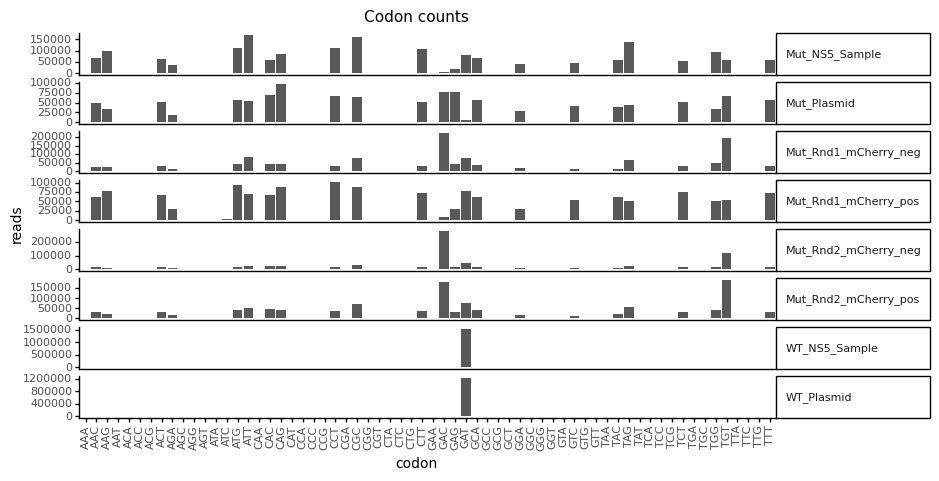

<ggplot: (8760581509247)>

In [21]:
codon_counts_plot = (p9.ggplot(codon_counts) +
                p9.aes(x='codon',
                       y='count') +
                p9.geom_bar(stat='identity') +
                p9.facet_grid('sample_name~', scales='free_y') +
                p9.ggtitle('Codon counts') +
                p9.labs(x='codon',
                        y='reads') +
                p9.theme(figure_size=(9, 5),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(size=8, rotation=90),
                         axis_text_y=p9.element_text(size=8),
                         strip_text_y=p9.element_text(size=8,angle=0, ha='left'),
                         strip_background_y=p9.element_text(width=0.22))
               )

display(codon_counts_plot)

Plot relative ratio of codons in mutant plasmid pool and mutant cell population

In [22]:
mut_codon_freqs = (
    results
    .query('(codon != "failed_parse") and '
           '(sample_name == "Mut_NS5_Sample" or '
           'sample_name == "Mut_Plasmid")')
    .groupby('sample_name')
    ['codon']
    .value_counts(normalize=True)
    .reset_index(name='frequency')
)

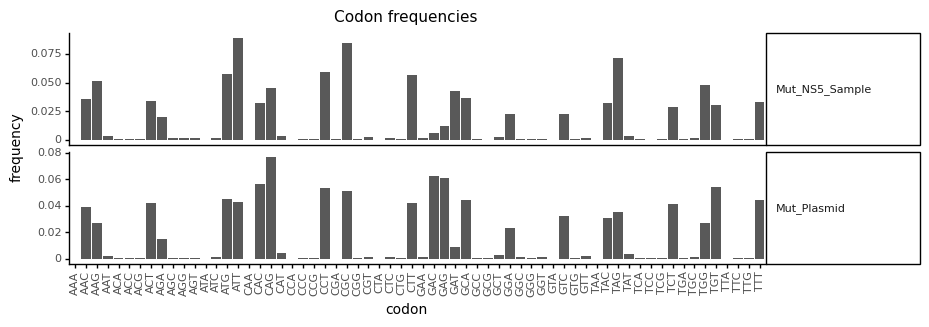

<ggplot: (8760581073568)>

In [23]:
mut_codon_freqs_plot = (p9.ggplot(mut_codon_freqs) +
                p9.aes(x='codon',
                       y='frequency') +
                p9.geom_bar(stat='identity') +
                p9.facet_grid('sample_name~', scales='free_y') +
                p9.ggtitle('Codon frequencies') +
                p9.labs(x='codon',
                        y='frequency') +
                p9.theme(figure_size=(9, 3),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(size=8, rotation=90),
                         axis_text_y=p9.element_text(size=8),
                         strip_text_y=p9.element_text(size=8,angle=0, ha='left'),
                         strip_background_y=p9.element_text(width=0.22))
               )

mut_codon_freqs_plot

### Calculate enrichment

To calculate enrichment, I will follow some of the general principals used to calculate [DMS amino acid preferences](https://jbloomlab.github.io/dms_tools2/prefs.html#prefs).

Conceptually, I am calculating the ratio of codon frequency in the selected condition compared to codon frequency in the reference condition. I add a pseudocount to accomodate missing codons in one of the two conditions. I take the log2 of the ratio.

**I am not normalizing codon frequency to the WT codon**, because I want to detect and display strong enrichment of the WT codon in the selected condition.

```Enrichment = log2( ((codon_count_selected + pseudocount) / (total_codon_count_selected)) /  
                   ((codon_count_reference + pseudocount) / (total_codon_count_reference)) )```

In [24]:
def calculate_enrichment(selected_sample,
                         reference_sample="Mut_NS5_Sample",
                         pseudocount=0.1):
    selected_freqs = (codon_counts
                      .query(f'sample_name == "{selected_sample}"')
                      [['codon', 'count']])
    selected_freqs['count_pseudo'] = selected_freqs['count'] + pseudocount
    selected_total = float(selected_freqs['count_pseudo'].sum())
    
    reference_freqs = (codon_counts
                       .query(f'sample_name == "{reference_sample}"')
                       [['codon', 'count']])
    reference_freqs['count_pseudo'] = reference_freqs['count'] + pseudocount
    reference_total = float(reference_freqs['count_pseudo'].sum())
    
    enrichment_df = pd.merge(
        left=selected_freqs,
        right=reference_freqs,
        on=['codon'],
        how='outer',
        validate='one_to_one',
        suffixes=['_selected','_reference'])
    enrichment_df['count_pseudo_selected'] = (enrichment_df['count_pseudo_selected']
                                              .fillna(pseudocount))
    enrichment_df['count_pseudo_reference'] = (enrichment_df['count_pseudo_reference']
                                              .fillna(pseudocount))
    
    enrichment_df['enrichment'] = (
        np.log2((enrichment_df['count_pseudo_selected'] / selected_total) /
                (enrichment_df['count_pseudo_reference'] / reference_total)))
    
    return(enrichment_df)

### Experiment Results

**Rnd1 IFN- population ("Mut_Rnd1_mCherry_neg")**  
Calculate codon enrichment in the population of NS5-expressing cells that successfully antagonize IFN.  


,codon,count_selected,count_pseudo_selected,count_reference,count_pseudo_reference,enrichment
0,GAC,222684,222684.1,7427,7427.1,5.442167
1,TGT,196330,196330.1,56610,56610.1,2.330261
2,ATT,80220,80220.1,169080,169080.1,-0.539560
3,CGC,79478,79478.1,162366,162366.1,-0.494510
4,GAT,74278,74278.1,79826,79826.1,0.432188
...,...,...,...,...,...,...
59,TAA,39,39.1,112,112.1,-0.983434
60,CAA,35,35.1,156,156.1,-1.616816
61,AAA,32,32.1,114,114.1,-1.293542
62,CTA,8,8.1,25,25.1,-1.095582


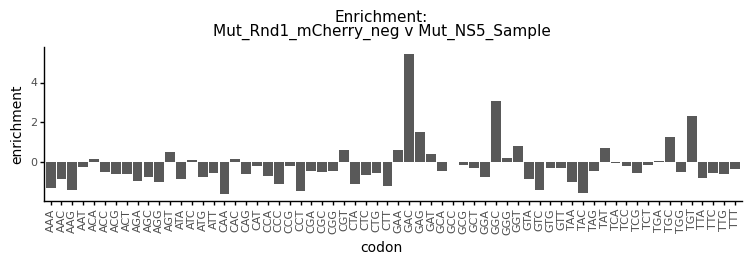

<ggplot: (8760580946707)>

In [25]:
selected_pop = "Mut_Rnd1_mCherry_neg"

Rnd1_IFN_neg_enrichment = calculate_enrichment(selected_pop)
display(Rnd1_IFN_neg_enrichment)

Rnd1_IFN_neg_plot = (p9.ggplot(Rnd1_IFN_neg_enrichment) +
                p9.aes(x='codon',
                       y='enrichment') +
                p9.geom_bar(stat='identity') +
                p9.ggtitle('Enrichment:\n'
                           f'{selected_pop} v Mut_NS5_Sample') +
                p9.labs(x='codon',
                        y='enrichment') +
                p9.theme(figure_size=(9, 2),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(size=8, rotation=90),
                         axis_text_y=p9.element_text(size=8))
               )

display(Rnd1_IFN_neg_plot)

**Rnd2 IFN- population ("Mut_Rnd2_mCherry_neg")**  
Calculate codon enrichment in the population of NS5-expressing cells that successfully antagonize IFN.  

,codon,count_selected,count_pseudo_selected,count_reference,count_pseudo_reference,enrichment
0,GAC,280350,280350.1,7427,7427.1,6.471761
1,TGT,121374,121374.1,56610,56610.1,2.333803
2,GAT,49232,49232.1,79826,79826.1,0.536213
3,CGC,29031,29031.1,162366,162366.1,-1.250105
4,TAG,22229,22229.1,136769,136769.1,-1.387747
...,...,...,...,...,...,...
59,CCG,13,13.1,69,69.1,-1.165645
60,TAA,13,13.1,112,112.1,-1.863674
61,CAA,9,9.1,156,156.1,-2.866986
62,CTA,4,4.1,25,25.1,-1.380518


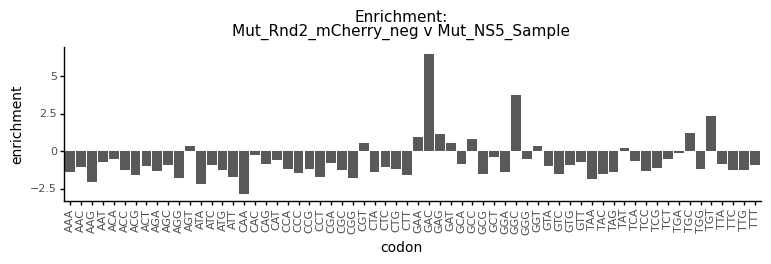

<ggplot: (8760580857278)>

In [26]:
selected_pop = "Mut_Rnd2_mCherry_neg"

Rnd2_IFN_neg_enrichment = calculate_enrichment(selected_pop)
display(Rnd2_IFN_neg_enrichment)

Rnd2_IFN_neg_plot = (p9.ggplot(Rnd2_IFN_neg_enrichment) +
                p9.aes(x='codon',
                       y='enrichment') +
                p9.geom_bar(stat='identity') +
                p9.ggtitle('Enrichment:\n'
                           f'{selected_pop} v Mut_NS5_Sample') +
                p9.labs(x='codon',
                        y='enrichment') +
                p9.theme(figure_size=(9, 2),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(size=8, rotation=90),
                         axis_text_y=p9.element_text(size=8))
               )

display(Rnd2_IFN_neg_plot)

**Single round vs two rounds of selection**  
Do the results differe if the cell population is sorted once, or sorted and then sorted again?

,codon,enrichment_Rnd1,enrichment_Rnd2
0,GAC,5.442167,6.471761
1,TGT,2.330261,2.333803
2,ATT,-0.539560,-1.697676
3,CGC,-0.494510,-1.250105
4,GAT,0.432188,0.536213
...,...,...,...
59,TAA,-0.983434,-1.863674
60,CAA,-1.616816,-2.866986
61,AAA,-1.293542,-1.422763
62,CTA,-1.095582,-1.380518


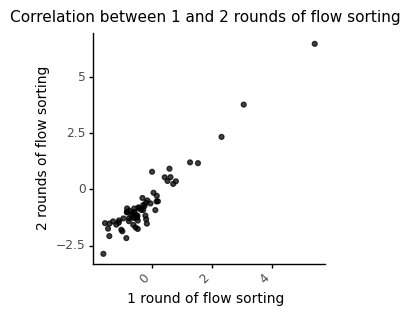

<ggplot: (8760581075213)>

In [27]:
corr_two_rounds = pd.merge(
    left=Rnd1_IFN_neg_enrichment[['codon','enrichment']],
    right=Rnd2_IFN_neg_enrichment[['codon','enrichment']],
    on='codon',
    how='outer',
    validate='one_to_one',
    suffixes=['_Rnd1', '_Rnd2']
)
display(corr_two_rounds)

corr_plot = (p9.ggplot(corr_two_rounds) +
              p9.aes(x='enrichment_Rnd1',
                     y='enrichment_Rnd2') +
              p9.geom_point(alpha=0.75) +
              p9.ggtitle('Correlation between 1 and 2 rounds of flow sorting') +
              p9.labs(x='1 round of flow sorting',
                      y='2 rounds of flow sorting') +
              p9.theme(figure_size=(3,3),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center')
              )

display(corr_plot)

**Failed agonist codons**  
What does the population that expresses NS5 mutants but still expresses IFN look like?

Rnd1 IFN+ population ("Mut_Rnd1_mCherry_pos") 
Calculate codon enrichment in the population of NS5-expressing cells that **fail to antagonize IFN**.  

,codon,count_selected,count_pseudo_selected,count_reference,count_pseudo_reference,enrichment
0,CCT,101606,101606.1,112566,112566.1,0.164633
1,ATG,93086,93086.1,110051,110051.1,0.070883
2,CGC,89707,89707.1,162366,162366.1,-0.543538
3,CAG,89088,89088.1,85729,85729.1,0.367866
4,GAT,77416,77416.1,79826,79826.1,0.268192
...,...,...,...,...,...,...
59,TCG,94,94.1,118,118.1,-0.015324
60,CAA,91,91.1,156,156.1,-0.464529
61,TAA,46,46.1,112,112.1,-0.969529
62,CTA,10,10.1,25,25.1,-1.000914


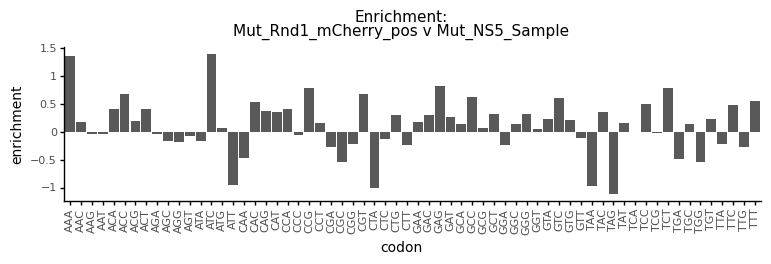

<ggplot: (8760581485731)>

In [28]:
selected_pop = "Mut_Rnd1_mCherry_pos"

Rnd1_IFN_pos_enrichment = calculate_enrichment(selected_pop)
display(Rnd1_IFN_pos_enrichment)

Rnd1_IFN_pos_plot = (p9.ggplot(Rnd1_IFN_pos_enrichment) +
                p9.aes(x='codon',
                       y='enrichment') +
                p9.geom_bar(stat='identity') +
                p9.ggtitle('Enrichment:\n'
                           f'{selected_pop} v Mut_NS5_Sample') +
                p9.labs(x='codon',
                        y='enrichment') +
                p9.theme(figure_size=(9, 2),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(size=8, rotation=90),
                         axis_text_y=p9.element_text(size=8))
               )

display(Rnd1_IFN_pos_plot)

,codon,enrichment_IFN_neg,enrichment_IFN_pos
0,GAC,5.442167,0.307749
1,TGT,2.330261,0.238083
2,ATT,-0.539560,-0.955415
3,CGC,-0.494510,-0.543538
4,GAT,0.432188,0.268192
...,...,...,...
59,TAA,-0.983434,-0.969529
60,CAA,-1.616816,-0.464529
61,AAA,-1.293542,1.361518
62,CTA,-1.095582,-1.000914


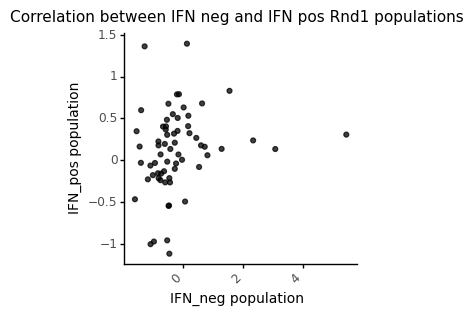

<ggplot: (8760580737284)>

In [29]:
Rnd1_pos_neg = pd.merge(
    left=Rnd1_IFN_neg_enrichment[['codon','enrichment']],
    right=Rnd1_IFN_pos_enrichment[['codon','enrichment']],
    on='codon',
    how='outer',
    validate='one_to_one',
    suffixes=['_IFN_neg', '_IFN_pos']
)
display(Rnd1_pos_neg)

Rnd1_pos_neg_plot = (p9.ggplot(Rnd1_pos_neg) +
              p9.aes(x='enrichment_IFN_neg',
                     y='enrichment_IFN_pos') +
              p9.geom_point(alpha=0.75) +
              p9.ggtitle('Correlation between IFN neg and IFN pos Rnd1 populations') +
              p9.labs(x='IFN_neg population',
                      y='IFN_pos population') +
              p9.theme(figure_size=(3,3),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center')
              )

display(Rnd1_pos_neg_plot)